In [2]:
%matplotlib inline

import os
import pandas as pd
import math
import re
import seaborn as sns
import numpy as np
import glob
from functools import reduce

import csv

from matplotlib import pyplot as plt
import matplotlib.dates as md
from datetime import datetime,timedelta

In [3]:
import matplotlib

plt.rcParams['figure.figsize'] = 50, 10
font = {'size'   : 30}
matplotlib.rc('font', **font)

In [4]:
import random

# Input

n = number of users

m = number of items

k = number of latent factors

g = number of agents

sigma = standard deviation of distribution

A = list of user vectors (a1...an)

B = list of item vectors (b1...bm)

In [5]:
class DataGenParameters:
    
    def __init__(self):
        self.num_users = 0
        self.num_items = 0
        self.num_factors = 0
        self.num_agents = 0
        self.std_dev_factors = 0
        self.initial_list_size = 0
        self.recommendation_size = 0
        self.user_feature_propensities = None
        self.item_feature_propensities = None

In [85]:
class DataGenIMF:
    
    DEFAULT_USER_PROPENSITY = (0.0, 1.0)
    DEFAULT_ITEM_PROPENSITY = 0.5
    
    def __init__(self, params: DataGenParameters):
        self.params = params
        self.users = None
        self.items = None
        self.user_factors = None
        self.item_factors = None
        self.ratings = None
        
    def generate_data(self):
        self.generate_users()
        self.generate_items()
        self.generate_factors()
        self.generate_ratings()
        
    def normalize_users(self):
        users_min, users_max = np.amin(self.users), np.amax(self.users)

        self.users_normalized = []
        for i, score in enumerate(self.users):
            self.users_normalized.append((score-users_min) / (users_max-users_min))
    
    def save_compatibilities(self):
        with open('compatibilities_users_factors.csv', 'w') as f:
            write = csv.writer(f)
            
            list_factors = []
            for i in range(self.params.num_factors): 
                list_factors.append(i+1)
            write.writerow(list_factors)
            
            write.writerows(self.users_normalized)
        
    def generate_users(self):
        if self.params.user_feature_propensities is None:
            self.params.user_feature_propensities = \
                [self.DEFAULT_USER_PROPENSITY] * self.params.num_factors
        self.users = []
        for i in range(self.params.num_users):
            user_i = []
            for factor in range(self.params.num_factors):
                mu_factor = self.params.user_feature_propensities[factor][0]
                sigma_factor = self.params.user_feature_propensities[factor][1]
                user_ij = np.random.normal(loc=mu_factor, scale=sigma_factor)
                user_i.append(user_ij)
            self.users.append(user_i)
            
        self.normalize_users()
        self.save_compatibilities()
            
    
    def generate_items(self):
        if self.params.item_feature_propensities is None:
            self.params.item_feature_propensities = \
                [self.DEFAULT_ITEM_PROPENSITY] * self.params.num_factors
        self.items = []
        for i in range(self.params.num_items):
            item_i = []
            for factor in range(self.params.num_factors):
                feature_p = self.params.item_feature_propensities[factor]
                choice_weights = (1 - feature_p, feature_p)
                item_ij = random.choices([0, 1], weights=choice_weights)
                item_i += item_ij
            self.items.append(item_i)

    def generate_factors(self):
        self.user_factors = self._create_latent_factors(self.users)
        self.item_factors = self._create_latent_factors(self.items)
        
    def _create_latent_factors(self, profile):
        factors = []
    
        for profile_i in profile:
            factor_i = []
            for j,profile_ij in enumerate(profile_i):
                if j+1 > self.params.num_agents:    # not an agent factor
                    factor_ij = np.random.normal(loc=0.0, 
                                                      scale=self.params.std_dev_factors, 
                                                      size=None)
                else:      # an agent factor
                    factor_ij = np.random.normal(loc=profile_ij, 
                                           scale=self.params.std_dev_factors, 
                                           size=None)
                factor_i.append(factor_ij)
            factors.append(factor_i)
        
        return np.array(factors)
    
    def generate_ratings(self):
        
        self.ratings = []
        
        for user, user_factor in enumerate(self.user_factors):
            
            list_items = np.random.choice(self.params.num_items, 
                                          size=self.params.initial_list_size, 
                                          replace=False)
            
            triples = []
            for item in list_items:
                item_factor = self.item_factors[item]
                score = np.dot(user_factor, item_factor)
                triples.append((user, item, score))
                
            triples.sort(key=lambda triple: triple[2], reverse=True)
            triples = triples[0:self.params.recommendation_size]
            
            self.ratings += triples
    
    def save_ratings(self, filename):
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            fields = ["user_id", "item_id", "score"]
            writer.writerow(fields)
    
            for user, item, score in self.triples:
                writer.writerow([user, item, score])


In [86]:
params1 = DataGenParameters()
params1.num_users = 3
params1.num_items = 10
params1.num_factors = 3
params1.num_agents = 2
params1.std_dev_factors = 1.0
params1.initial_list_size = 10
params1.recommendation_size = 5

In [87]:
generator1 = DataGenIMF(params1)

In [88]:
generator1.generate_data()

In [93]:
generator1.ratings

[(0, 4, 6.525384040094517),
 (0, 6, 6.220402391139951),
 (0, 2, 4.884386413352244),
 (0, 0, 2.740229427660941),
 (0, 1, 1.6899126264111772),
 (1, 3, 2.915780913099182),
 (1, 6, 2.5825785116191065),
 (1, 7, 1.712124078413893),
 (1, 2, 0.5356959852154607),
 (1, 8, 0.20603268561494809),
 (2, 3, 2.4698954932193584),
 (2, 8, 1.5138725799429105),
 (2, 0, 0.3398384366373999),
 (2, 1, -0.6887523400007574),
 (2, 5, -0.9047163158757066)]

In [97]:
import copy

params2 = copy.copy(params1)
params2.user_feature_propensities=[(0.0, 1.0), (0.5, 1.0), (0.9, 1.0)]
params2.item_feature_propensities=[0.1, 0.5, 0.9]

In [98]:
generator2 = DataGenIMF(params2)
generator2.generate_data()
generator2.ratings

[(0, 2, 1.5215913383420758),
 (0, 1, 1.2240590277143426),
 (0, 8, 0.7442897280917121),
 (0, 4, 0.12920927590444745),
 (0, 3, -0.05954888468098948),
 (1, 3, 1.6985284075416904),
 (1, 2, 0.9413599683296214),
 (1, 4, 0.42292521845636555),
 (1, 7, 0.39994760056943546),
 (1, 5, -0.5097219858327557),
 (2, 3, 1.4515238833843385),
 (2, 5, 1.387074663695095),
 (2, 7, 0.7007909548099631),
 (2, 0, -0.15891241510043486),
 (2, 2, -0.24625466567461815)]

In [99]:
import seaborn as sbn


In [110]:
df = pd.DataFrame(generator2.ratings)
df.columns = ['user', 'item', 'score']

In [111]:
df['score']

0     1.521591
1     1.224059
2     0.744290
3     0.129209
4    -0.059549
5     1.698528
6     0.941360
7     0.422925
8     0.399948
9    -0.509722
10    1.451524
11    1.387075
12    0.700791
13   -0.158912
14   -0.246255
Name: score, dtype: float64

<AxesSubplot:xlabel='item', ylabel='score'>

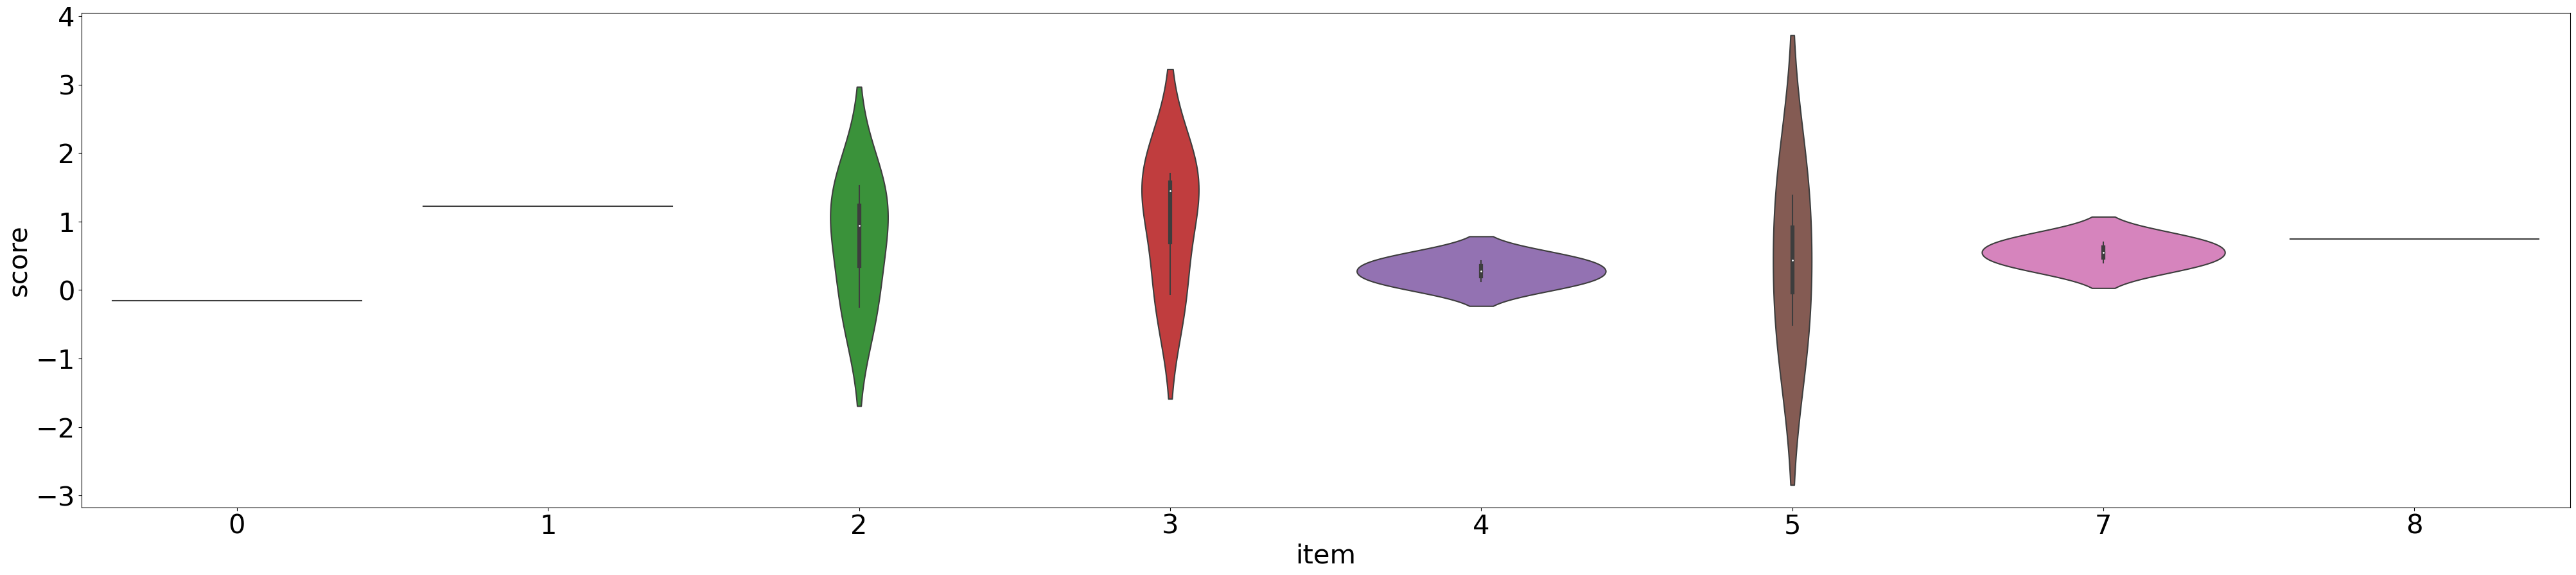

In [120]:
sbn.violinplot(data=df, y='score', x='item')

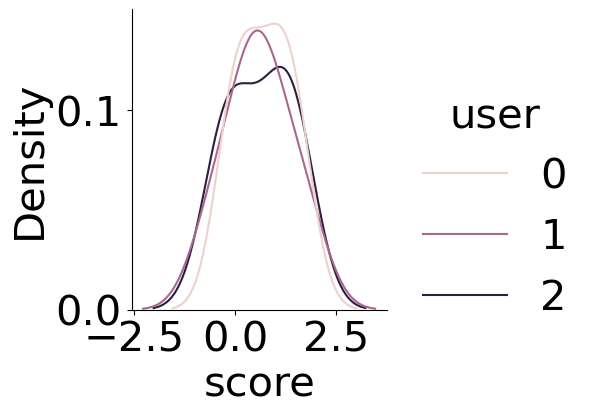

In [123]:
sbn.displot(data=df, x='score', hue='user', kind='kde')

<AxesSubplot:>

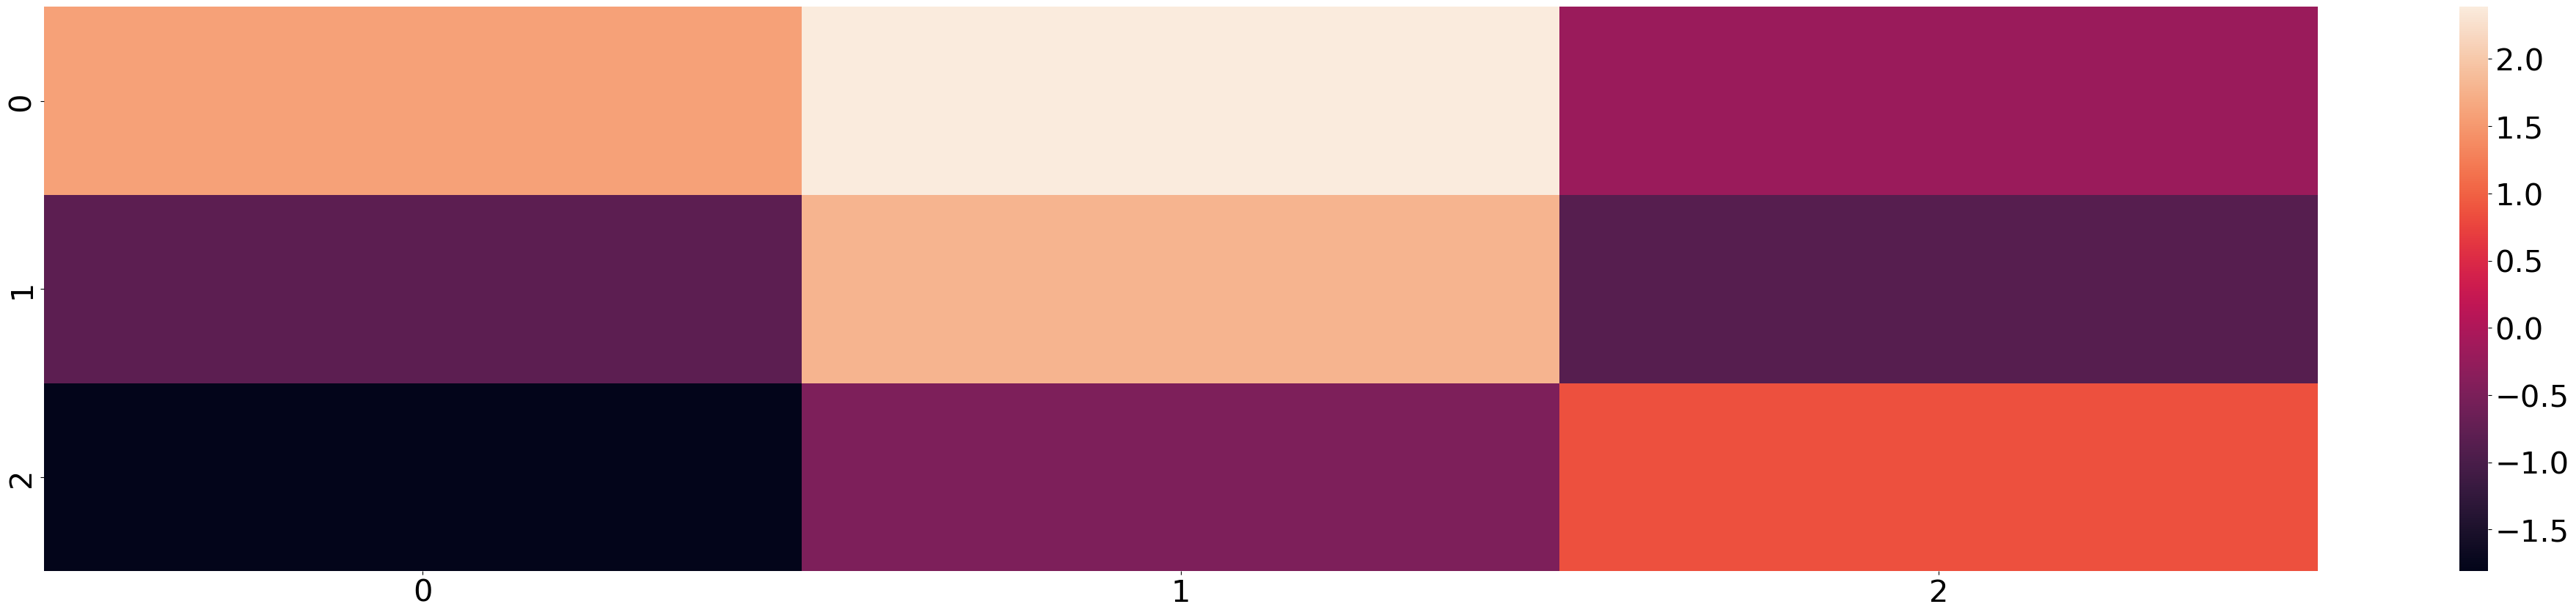

In [124]:
sbn.heatmap(data=generator1.user_factors)

<AxesSubplot:>

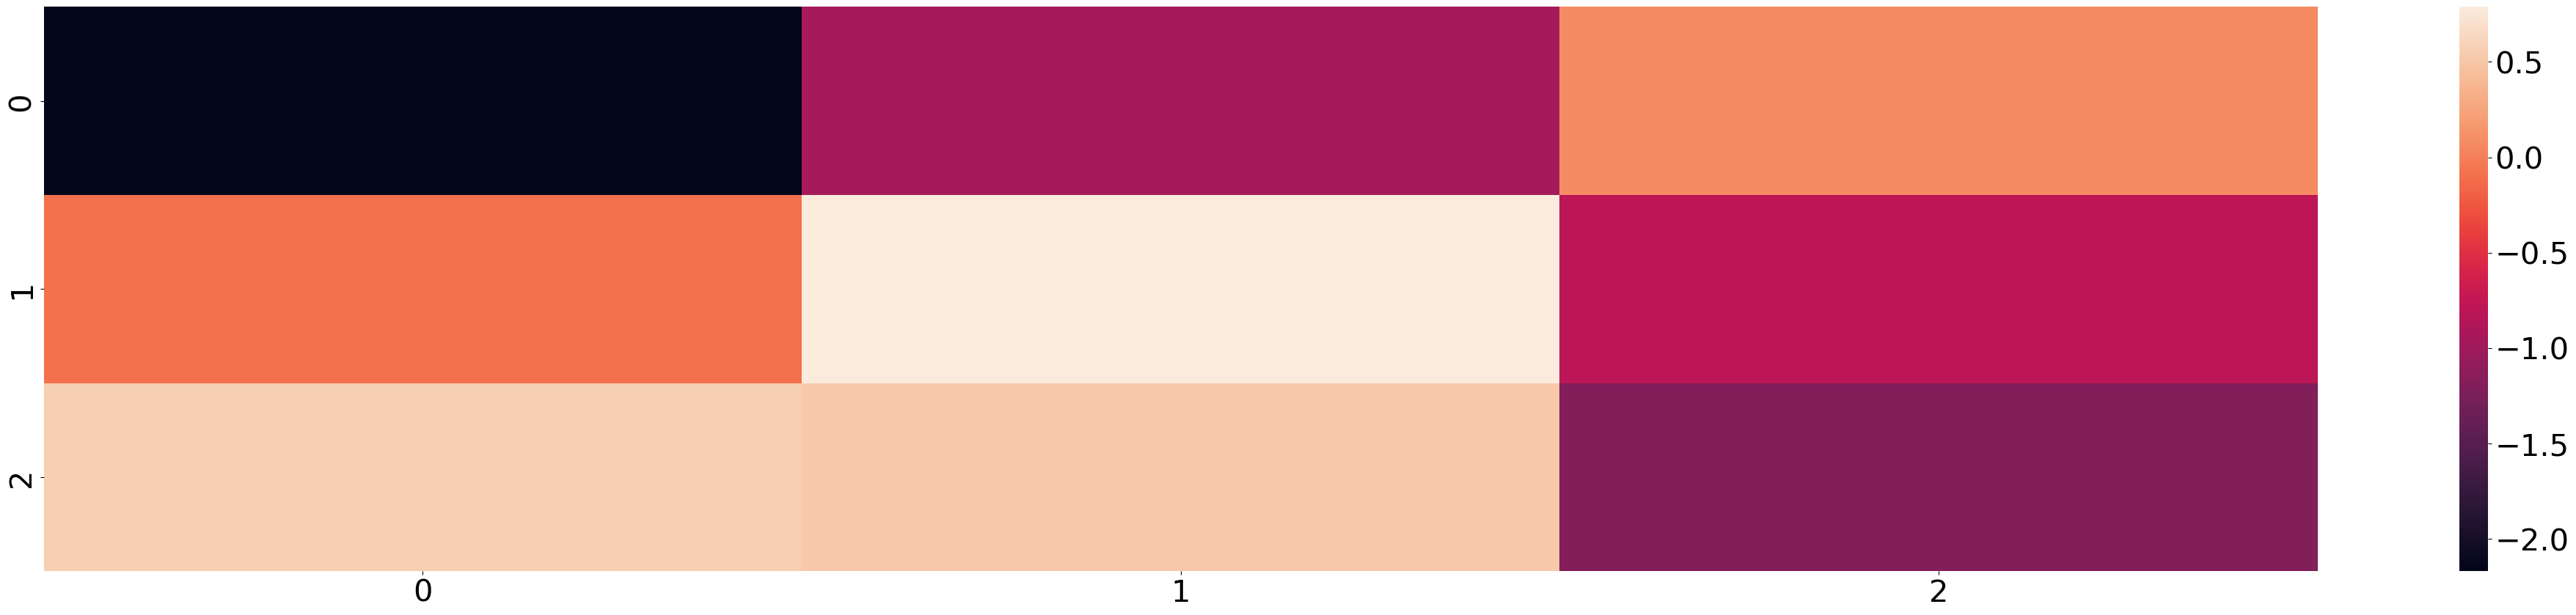

In [117]:
sbn.heatmap(data=generator2.user_factors)

<AxesSubplot:>

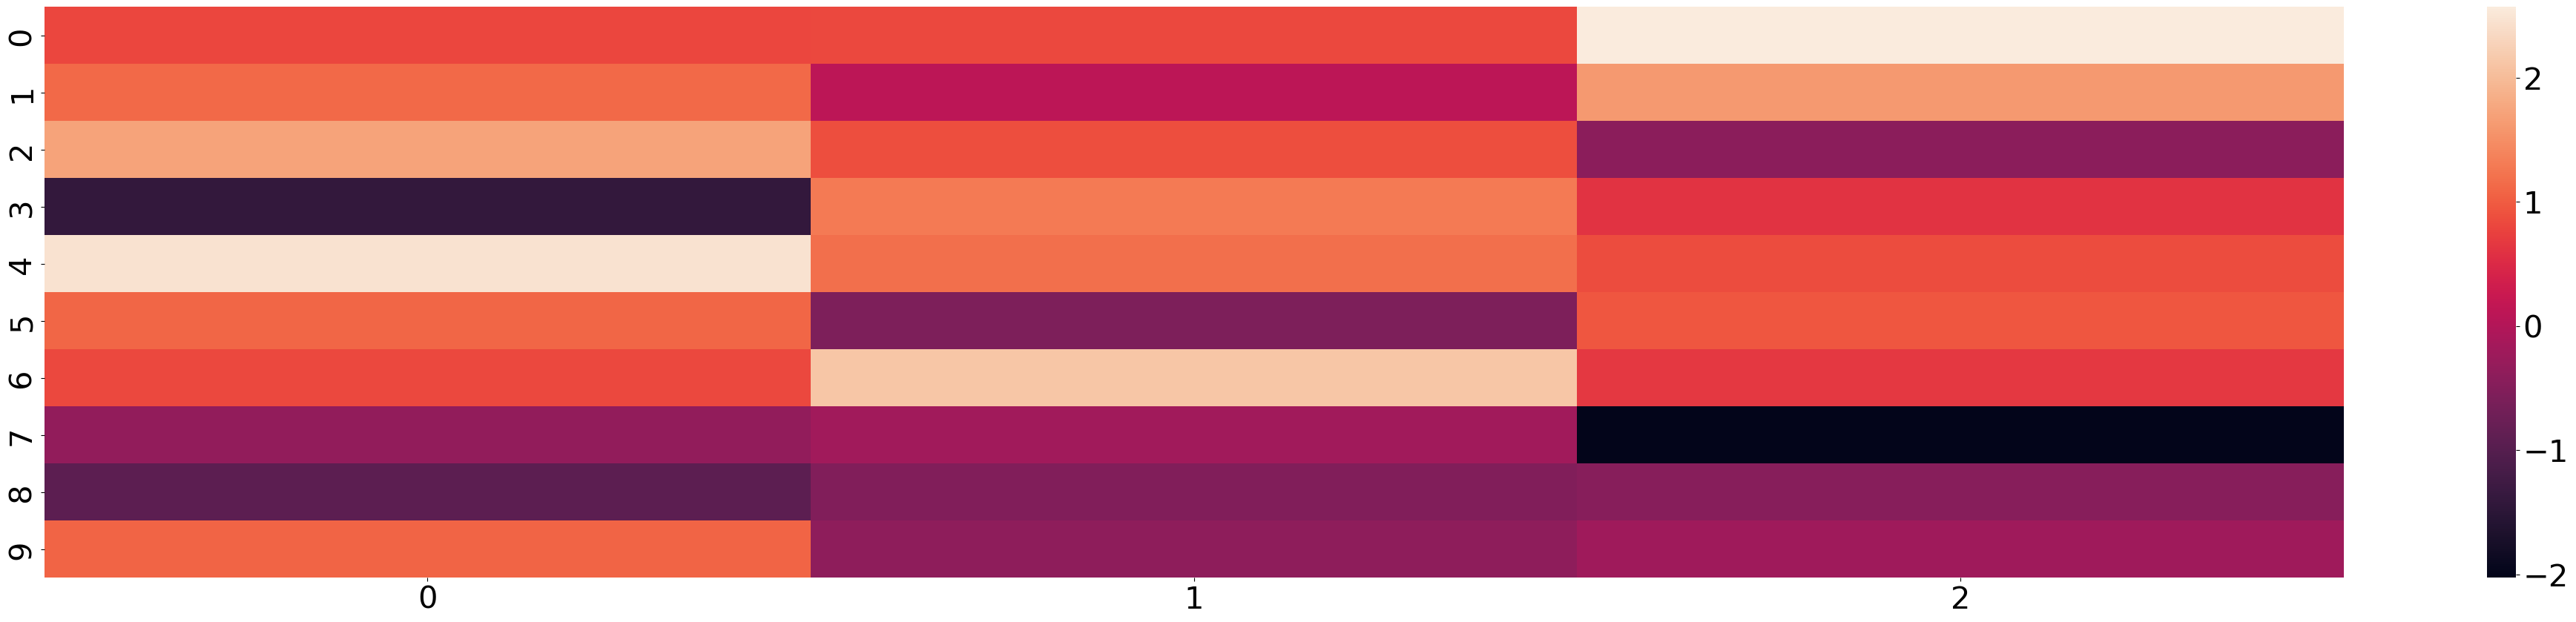

In [125]:
sbn.heatmap(data=generator1.item_factors)

<AxesSubplot:>

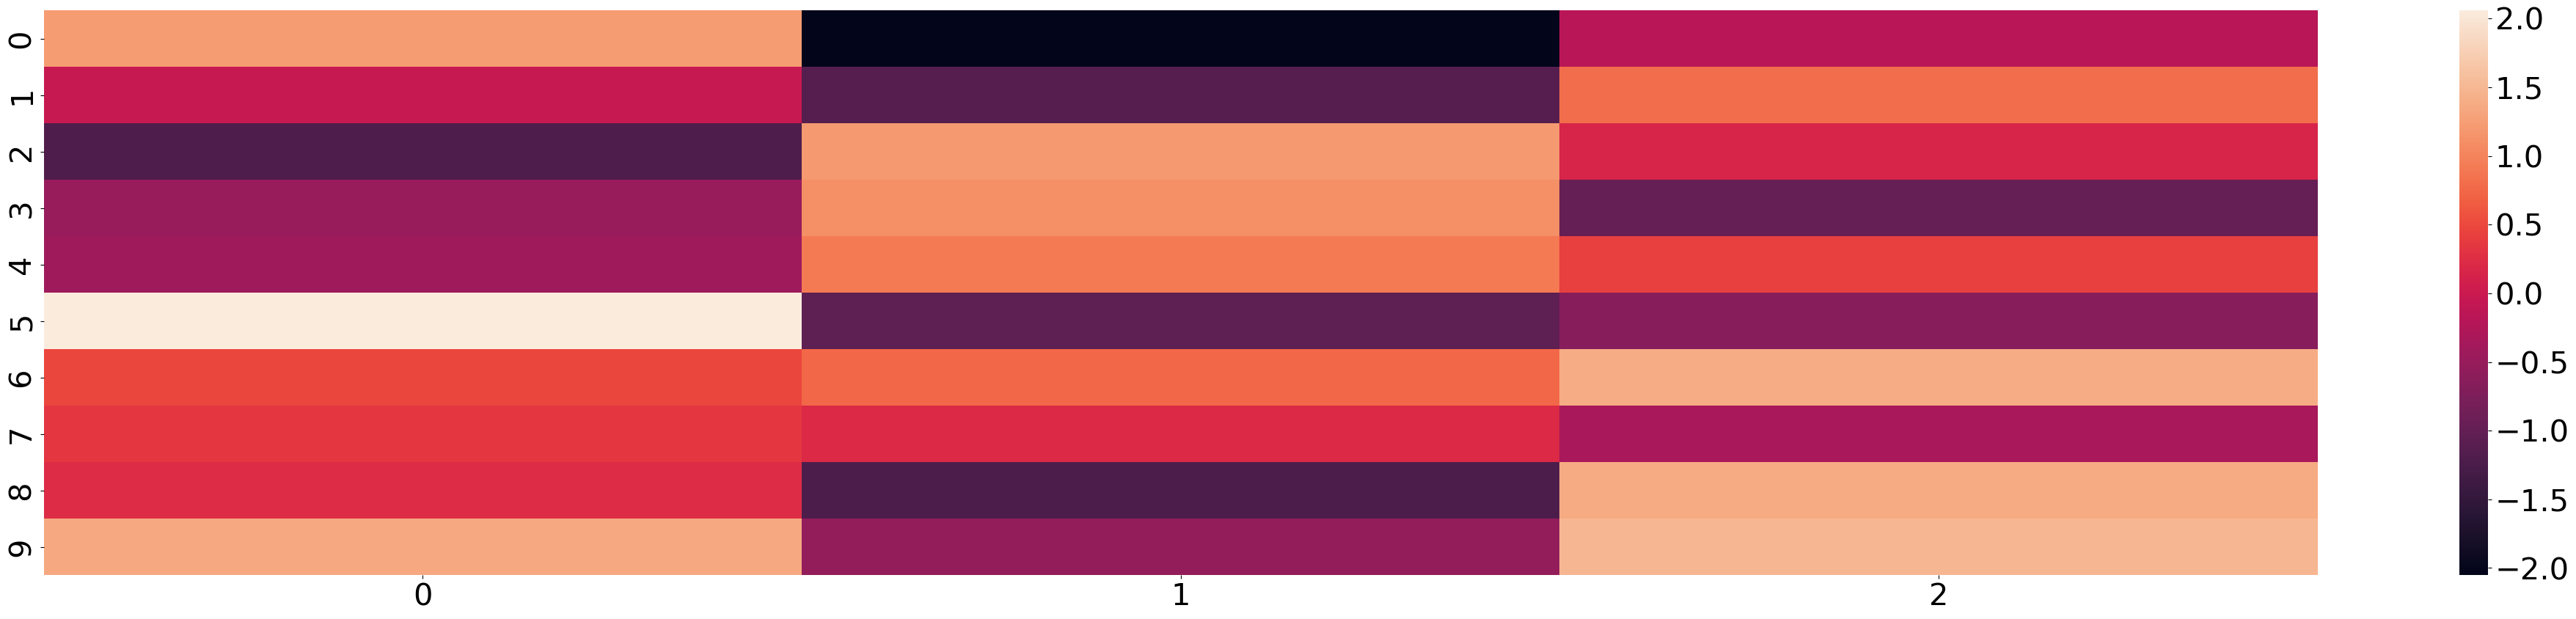

In [118]:
sbn.heatmap(data=generator2.item_factors)

In [20]:
n = 3
m = 10

k = 3
g = 2
sigma = 1.0

delta
l = length of recommendations list

alpha = how big of a portion of items are selected - constant to be multiplied by lenght 

U = users latent factor matrix - scale of -1 to 1

V = items latent factor matrix - binary (0/1)

In [18]:
l = 10
alpha = 0.5

# U = np.array(
#     [[0.0, 0.2, 0.3],
#     [-1.0, 0.0, 0.5],
#     [-0.6, 1.0, -3.0]])

# V = np.array(
#     [[0,1,0],
#     [1,0,0],
#     [1,0,1]])

# Users/items Generation

In [6]:
# theoretically one function with a switch

In [49]:
A = generate_users(n=n)
B = generate_items(m=m)

In [50]:
A

[[1.87, 0.67, -0.39], [-1.18, 0.87, -0.09], [0.37, -1.05, 0.53]]

In [39]:
B

[[0, 0, 0],
 [1, 0, 1],
 [1, 0, 0],
 [0, 1, 1],
 [0, 0, 0],
 [0, 0, 0],
 [1, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 0, 1]]

In [51]:
A = generate_users(n=n, feature_propensities=[(0.0, 1.0), (0.5, 1.0), (0.9, 1.0)])

In [52]:
A

[[0.54, -0.78, 1.88], [-0.09, 0.47, 0.84], [-2.0, -0.41, 1.94]]

In [41]:
B = generate_items(m=m, feature_propensities=[0.1, 0.5, 0.9])

In [42]:
B

[[0, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1],
 [0, 0, 1],
 [1, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 1],
 [0, 0, 1]]

# Factors Generation

In [54]:
U = create_user_factors(k,g,A,sigma) # users
V = create_user_factors(k,g,B,sigma) # items

In [55]:
U

array([[ 1.24533955,  0.29017701,  1.0741475 ],
       [-0.89462397, -0.42090447,  0.59256929],
       [-2.71469512,  0.51461819,  0.29126728]])

In [56]:
V

array([[-0.35442687,  0.47502763,  1.35806228],
       [ 2.65932954,  1.0879131 , -0.9979858 ],
       [-0.10759669,  1.6630272 ,  1.10070368],
       [ 0.8692034 ,  1.62714579,  0.00879153],
       [-0.33483999, -0.54786854,  0.71128935],
       [ 1.36498284, -1.42940606,  0.48044305],
       [ 0.43710815, -1.14858875,  0.67854883],
       [ 1.23533753, -0.37251224,  0.39145879],
       [-0.83172551,  1.04328909, -0.86121544],
       [ 2.40842204,  2.63912738, -0.33975952]])

# Ratings Generation

In [58]:
generating_ratings(alpha=alpha,l=l,U=U,V=V)